# 1. Gráfico Rendimento Modelos

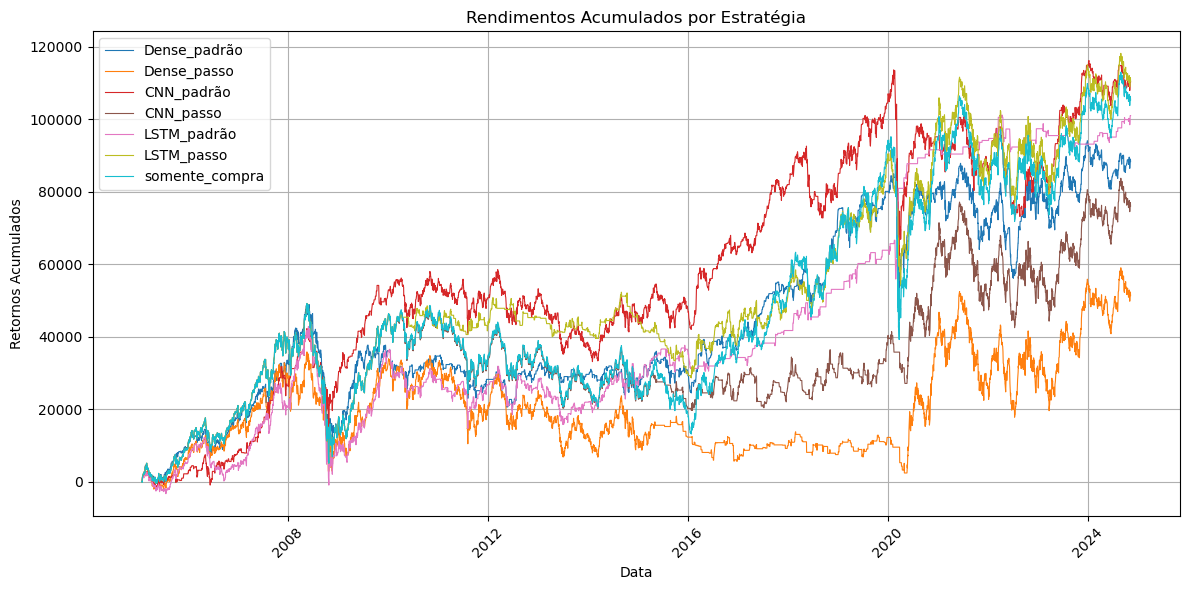

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Lista de arquivos CSV
arquivos = [
    'profit_by_date_historico_5ano_Dense_default.csv',
    'profit_by_date_historico_5ano_Dense_step.csv',
    'profit_by_date_historico_5ano_CNN_default.csv',
    'profit_by_date_historico_5ano_CNN_step.csv',
    'profit_by_date_historico_5ano_LSTM_default.csv',
    'profit_by_date_historico_5ano_LSTM_step.csv',
    'profit_by_date_historico_somente_compra.csv'
]

# Lista para armazenar os resultados e os rótulos
resultados = []
labels = []

# Processando cada arquivo
for i, arquivo in enumerate(arquivos):
    df = pd.read_csv(arquivo)
    # Convertendo a coluna 'Date' para o tipo datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Criando rótulo a partir da parte [5] e [6] do nome do arquivo
    partes = arquivo.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"  # Remove a extensão do arquivo na parte [5]
    label = label.replace('default', 'padrão').replace('step', 'passo')  # Modificando para 'padrão' e 'passo'
    labels.append(label)

    if label != 'somente_compra':
        valor_somar = df.loc[df['Date'] == '2010-03-09', 'Profit'].values[0]
        df.loc[(df['Date'] > '2010-03-09') & (df['Date'] < '2015-04-13'), 'Profit'] += valor_somar
        valor_somar = df.loc[df['Date'] == '2015-04-10', 'Profit'].values[0]
        df.loc[(df['Date'] >= '2015-04-13') & (df['Date'] <= '2020-05-18'), 'Profit'] += valor_somar
        valor_somar = df.loc[df['Date'] == '2020-05-18', 'Profit'].values[0]
        df.loc[df['Date'] > '2020-05-18', 'Profit'] += valor_somar
    


    resultados.append((df['Date'], df['Profit'], label))

# Criar gráfico único com todas as curvas
plt.figure(figsize=(12, 6))

# Definir cores diferentes para cada curva
cores = plt.cm.tab10(np.linspace(0, 1, len(resultados)))

for i, (dates, profits, label) in enumerate(resultados):
    plt.plot(dates, profits, color=cores[i], linewidth=0.8, label=label)

# Personalizar o gráfico
plt.title('Rendimentos Acumulados por Estratégia')
plt.xlabel('Data')
plt.ylabel('Retornos Acumulados')
plt.xticks(rotation=45)  # Girar as datas no eixo X para melhor visualização
plt.grid(True)
plt.legend()
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.savefig('Plots/Gráficos rendimentos acumulados.jpg')


 # 2. Indicadores

## 2.1 Criando arquivos para a estrategia somente compra

In [118]:
# Ler e processar dados de preços ajustados
data_inicio = pd.to_datetime('2005-01-31')
data_final = pd.to_datetime('2024-11-07')

dados_df = pd.read_csv('data/ibovespa_2000_2024.csv')
dados_df['Date'] = pd.to_datetime(dados_df['Date'])
dados_df = dados_df[dados_df['Date'] <= data_final]
dados_df = dados_df[dados_df['Date'] >= data_inicio]
dados_df['Profit'] = dados_df['Adj Close'] - dados_df['Adj Close'].iloc[0]
dados_df = dados_df[['Date','Profit']]
dados_df.to_csv('profit_by_date_historico_somente_compra.csv', index=False)
resultados = []

# Índice inicial
i = 0
while i < len(dados_df)-1:   
    if i + 21 <= len(dados_df)-1: 
        negociacao = dados_df.iloc[i+21]['Profit'] - dados_df.iloc[i]['Profit']
        resultados.append({'Date': dados_df.iloc[i+21]['Date'], 'Valores': negociacao})
        i += 21
    else:
        negociacao = dados_df.iloc[len(dados_df)-1]['Profit'] - dados_df.iloc[i]['Profit']
        resultados.append({'Date': dados_df.iloc[len(dados_df)-1]['Date'], 'Valores': negociacao})
        i = len(dados_df)-1

# Criando um novo DataFrame com os resultados
df_negociacoes = pd.DataFrame(resultados)
df_negociacoes.to_csv('negociações_valores_historico_somente_compra.csv', index=False)



## 2.2 Tabela indicadores

In [20]:
import pandas as pd

# Lista de arquivos
arquivos_profit = [
    'profit_by_date_historico_5ano_Dense_default.csv',
    'profit_by_date_historico_5ano_Dense_step.csv',
    'profit_by_date_historico_5ano_CNN_default.csv',
    'profit_by_date_historico_5ano_CNN_step.csv',
    'profit_by_date_historico_5ano_LSTM_default.csv',
    'profit_by_date_historico_5ano_LSTM_step.csv',
    'profit_by_date_historico_somente_compra.csv'
]
arquivos_negociacoes = [
    'negociações_valores_historico_5ano_Dense_default.csv',
    'negociações_valores_historico_5ano_Dense_step.csv',
    'negociações_valores_historico_5ano_CNN_default.csv',
    'negociações_valores_historico_5ano_CNN_step.csv',
    'negociações_valores_historico_5ano_LSTM_default.csv',
    'negociações_valores_historico_5ano_LSTM_step.csv',
    'negociações_valores_historico_somente_compra.csv'
]

# df taxa selic
df_taxa_selic = pd.read_csv('taxa_selic_anual_2000_2024.csv')
df_taxa_selic.loc[df_taxa_selic['Taxa Selic Anual Média'] == 0, 'Taxa Selic Anual Média'] = pd.NA
df_taxa_selic['Taxa Selic Anual Média'] = df_taxa_selic['Taxa Selic Anual Média'].fillna(method='ffill')

# df ibovespa -> valor do início do investimento 
df = pd.read_csv('data/ibovespa_2000_2024.csv')
df['Date'] = pd.to_datetime(df['Date'])
preco_inicial = df[df['Date'] == '2005-01-31']['Adj Close'].iloc[0]

# Dicionário para armazenar os indicadores de todos os arquivos
dicionario_indicadores = {}

for arquivo_profit, arquivo_negociacoes in zip(arquivos_profit, arquivos_negociacoes):
    # Importando os DataFrames
    df = pd.read_csv(arquivo_profit)
    df['Date'] = pd.to_datetime(df['Date']) 
    df_negociacoes = pd.read_csv(arquivo_negociacoes)
    
    # Criando label único para os arquivos
    partes = arquivo_profit.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"
    
    # Ajustando o df profit para ter uma evolução contínua (evitar erros devido a diferentes testes)
    if label != 'somente_compra':
        valor_somar = df.loc[df['Date'] == '2010-03-09', 'Profit'].values[0]
        df.loc[(df['Date'] > '2010-03-09') & (df['Date'] < '2015-04-13'), 'Profit'] += valor_somar
        valor_somar = df.loc[df['Date'] == '2015-04-10', 'Profit'].values[0]
        df.loc[(df['Date'] >= '2015-04-13') & (df['Date'] <= '2020-05-18'), 'Profit'] += valor_somar
        valor_somar = df.loc[df['Date'] == '2020-05-18', 'Profit'].values[0]
        df.loc[df['Date'] > '2020-05-18', 'Profit'] += valor_somar

    df["Year"] = df["Date"].dt.year
    last_day_profit = (
        df.groupby("Year")
        .agg(Ultimo=("Profit", "last"))
        .reset_index()
    )
    last_day_profit["Diferença"] = 0
    for i in range(len(last_day_profit)):
        if i == 0:
            last_day_profit.loc[i, "Diferença"] = last_day_profit.loc[i, "Ultimo"] - 0
        else:
            last_day_profit.loc[i, "Diferença"] = (
                last_day_profit.loc[i, "Ultimo"] - last_day_profit.loc[i - 1, "Ultimo"]
            )

    # Retornos - rendimento livre de risco  --> Considerando um investimento iniciado no primeiro dia do conjunto de testes
    rendimento_anual = last_day_profit["Diferença"] 
    retornos_medio_anual = rendimento_anual.mean()    
    last_day_profit = pd.merge(last_day_profit, df_taxa_selic, left_on='Year', right_on='Ano', how='inner')
    rendimento_livre_risco = []

    for i, row in last_day_profit.iterrows():
        if i == 0:
            livre_risco = (row['Taxa Selic Anual Média']) * preco_inicial
            last_day_profit.at[0, 'rendimento_livre_risco'] = livre_risco
            rendimento_livre_risco.append(livre_risco)
        else: 
            livre_risco = (row['Taxa Selic Anual Média']) * (preco_inicial + livre_risco)
            last_day_profit.at[i, 'rendimento_livre_risco'] = livre_risco
            rendimento_livre_risco.append(livre_risco)

    retornos_medio_anual = (last_day_profit["Diferença"] - last_day_profit['rendimento_livre_risco']).mean()

    # desvio padrão rendimentos
    desvio_padrao_rendimento_anual = rendimento_anual.std()              

    # Acertividade
    total_valores = len(df_negociacoes['Valores'])
    valores_positivos = df_negociacoes[df_negociacoes['Valores'] > 0].count()[0]
    percentual_positivos = (valores_positivos / total_valores) * 100

    # Razão de rendimentos positivos pelos negativos
    soma_positivos = df_negociacoes[df_negociacoes['Valores'] > 0]['Valores'].sum()
    soma_negativos_modulo = abs(df_negociacoes[df_negociacoes['Valores'] < 0]['Valores'].sum())
    razao_retornos = soma_positivos / soma_negativos_modulo

    # Índice Sharpe
    sharpe = retornos_medio_anual / desvio_padrao_rendimento_anual

    # Máxima perda acumulada
# Filtrar o DataFrame por um ano específico (exemplo: 2020)
    anos_unicos = df['Year'].unique().tolist()
    rebaixamento_max = 0
    for ano in anos_unicos:
        df_filtrado = df[df['Date'].dt.year == ano]
        df_filtrado = df_filtrado.copy()
        df_filtrado['Max_Valor_Acumulado'] = df_filtrado['Profit'].cummax()
        df_filtrado['Drawdown_Absoluto'] = df_filtrado['Max_Valor_Acumulado'] - df_filtrado['Profit']
        perda_maxima_acumulada = df_filtrado['Drawdown_Absoluto'].max()
        if rebaixamento_max < perda_maxima_acumulada:
            rebaixamento_max = perda_maxima_acumulada

    # Índice Sortino
    valores_negativos = df_negociacoes[df_negociacoes['Valores'] < 0]['Valores']
    desvio_padrao_perdas = valores_negativos.std()
    sortino = retornos_medio_anual / desvio_padrao_perdas

    # Índice de Calmar
    calmar = retornos_medio_anual / rebaixamento_max


    # Armazenando os dados no dicionário
    dicionario_indicadores[label] = {
        'retorno medio anual': retornos_medio_anual,
        'desvio padrao': desvio_padrao_rendimento_anual,
        'desvio padrao perdas':desvio_padrao_perdas,
        'acertividade': percentual_positivos,
        'razao de rendimentos': razao_retornos,
        'sharpe': sharpe,
        'perda maxima': rebaixamento_max,
        'sortino': sortino,
        'calmar': calmar
    }

df_indicadores = pd.DataFrame.from_dict(dicionario_indicadores, orient='index')

# Exibindo o DataFrame
df_indicadores

,retorno medio anual,desvio padrao,desvio padrao perdas,acertividade,razao de rendimentos,sharpe,perda maxima,sortino,calmar
Dense_default,1596.176081,10724.417821,2485.091651,67.979670,1.203343,0.148836,43654.0,0.642301,0.036564
Dense_step,-252.423919,12517.614913,1796.466570,43.457944,1.341868,-0.020165,32892.0,-0.140511,-0.007674
CNN_default,2695.076081,11887.954959,3733.157207,66.666667,1.302070,0.226706,53104.0,0.721929,0.050751
CNN_step,982.526081,14459.733001,2000.106284,36.666667,1.699465,0.067949,44082.0,0.491237,0.022289
LSTM_default,2230.276081,10256.912395,1522.987540,70.648968,1.356873,0.217441,43731.0,1.464409,0.051000
LSTM_step,2705.226081,14248.476918,1658.898787,36.040609,1.726589,0.189861,44082.0,1.630736,0.061368
somente_compra,2446.576081,15066.941081,4778.861195,56.410256,1.273761,0.162380,55958.0,0.511958,0.043722


 # 3. Gráficos Extras
 

## 3.1 Box plot

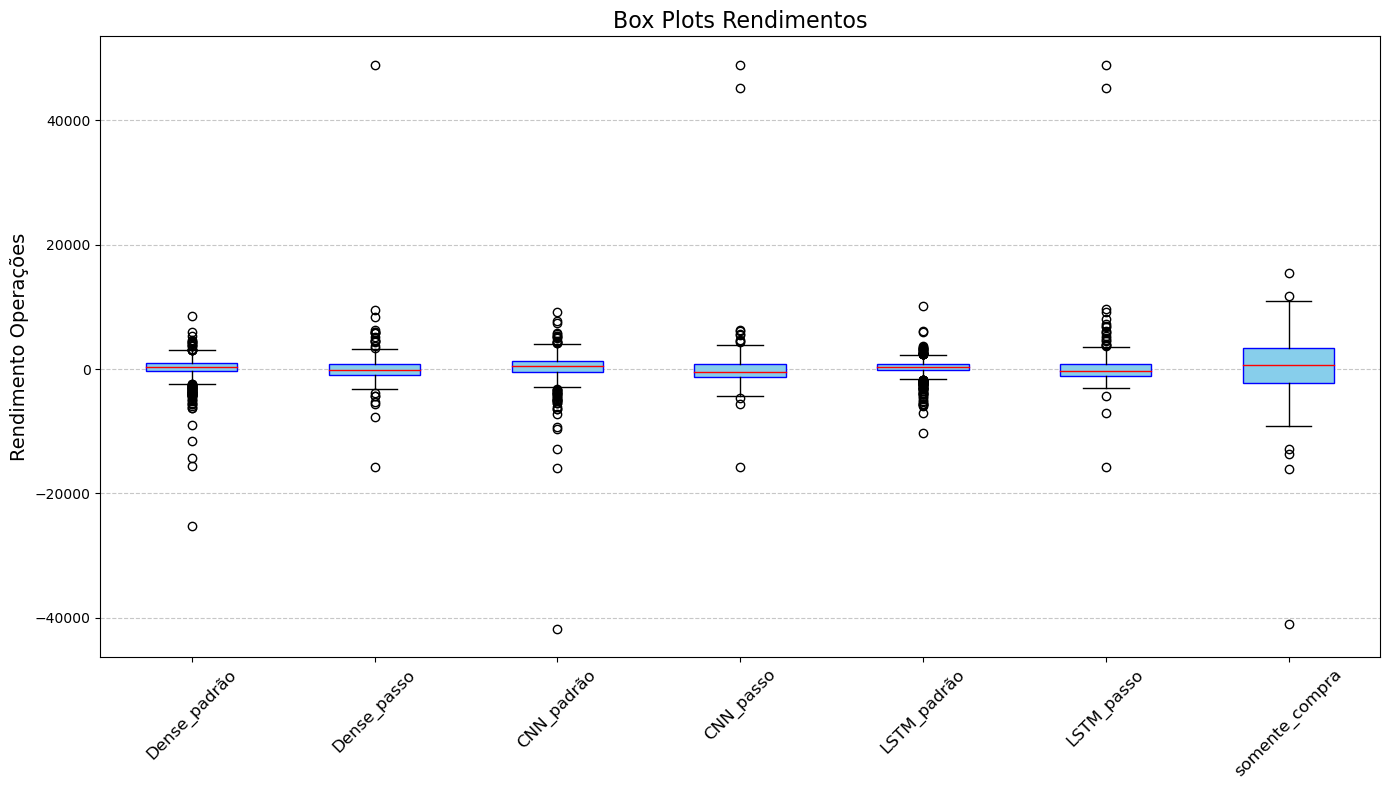

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregando os DataFrames
arquivos = [
    'negociações_valores_historico_5ano_Dense_default.csv',
    'negociações_valores_historico_5ano_Dense_step.csv',
    'negociações_valores_historico_5ano_CNN_default.csv',
    'negociações_valores_historico_5ano_CNN_step.csv',
    'negociações_valores_historico_5ano_LSTM_default.csv',
    'negociações_valores_historico_5ano_LSTM_step.csv',
    'negociações_valores_historico_somente_compra.csv'
]

# Lista para armazenar os valores de cada DataFrame
valores_dfs = []
labels = []

for arquivo in arquivos:
    df = pd.read_csv(arquivo)
    valores_dfs.append(df['Valores'])  # Supondo que todos os arquivos têm a coluna 'Valores'
    
    # Criando rótulos com as partes ajustadas
    partes = arquivo.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"  # Remove extensão da parte [5]
    label = label.replace("step", "passo").replace("default", "padrão")  # Substituições
    labels.append(label)

# Criando o box plot
plt.figure(figsize=(14, 8))
plt.boxplot(
    valores_dfs,  # Dados de todos os DataFrames
    labels=labels,  # Rótulos para cada box plot
    patch_artist=True,  # Permite personalizar as cores
    boxprops=dict(facecolor="skyblue", color="blue"),  # Cor da caixa
    medianprops=dict(color="red"),  # Cor da mediana
)

plt.title('Box Plots Rendimentos', fontsize=16)  # Título maior
plt.ylabel('Rendimento Operações', fontsize=14)  # Rótulo do eixo Y maior
plt.xticks(rotation=45, fontsize=12)  # Rótulos rotacionados e ampliados
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.savefig('Plots/Box plot rendimentos.jpg')


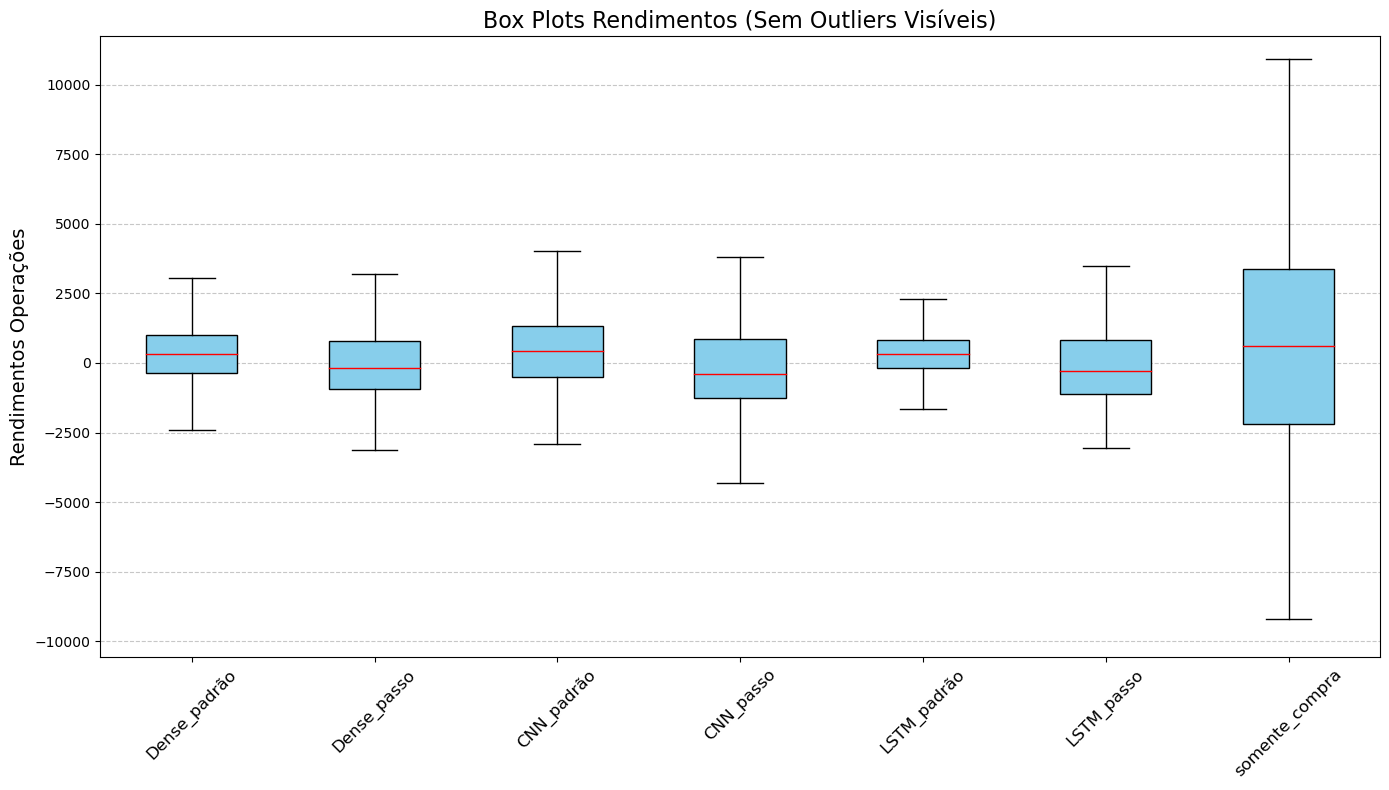

In [130]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregando os DataFrames
arquivos = [
    'negociações_valores_historico_5ano_Dense_default.csv',
    'negociações_valores_historico_5ano_Dense_step.csv',
    'negociações_valores_historico_5ano_CNN_default.csv',
    'negociações_valores_historico_5ano_CNN_step.csv',
    'negociações_valores_historico_5ano_LSTM_default.csv',
    'negociações_valores_historico_5ano_LSTM_step.csv',
    'negociações_valores_historico_somente_compra.csv'
]

# Lista para armazenar os valores de cada DataFrame
valores_dfs = []
labels = []

# Coletando dados e rótulos
for arquivo in arquivos:
    df = pd.read_csv(arquivo)
    valores_dfs.append(df['Valores'])  # Supondo que todos os arquivos têm a coluna 'Valores'
    
    # Criando rótulos com as partes ajustadas
    partes = arquivo.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"  # Remove extensão da parte [5]
    label = label.replace("step", "passo").replace("default", "padrão")  # Substituições
    labels.append(label)

# Calculando os limites do eixo Y com base no intervalo interquartil (IQR)
y_max = max([
    df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    for df in valores_dfs
])
y_min = min([
    df.quantile(0.25) - 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    for df in valores_dfs
])

# Criando o box plot
plt.figure(figsize=(14, 8))
plt.boxplot(
    valores_dfs,
    labels=labels,  # Rótulos para cada box plot
    patch_artist=True,  # Permite personalizar as cores
    boxprops=dict(facecolor="skyblue", color="black"),  # Cor da caixa
    medianprops=dict(color="red"),  # Cor da mediana
    showfliers=False,  # Oculta os *outliers*
)

# Ajustando o título e os rótulos
plt.title('Box Plots Rendimentos (Sem Outliers Visíveis)', fontsize=16)  # Título maior
plt.ylabel('Rendimentos Operações', fontsize=14)  # Rótulo do eixo Y maior
plt.xticks(rotation=45, fontsize=12)  # Rótulos rotacionados e ampliados
plt.ylim(y_min, y_max)  # Define os limites do eixo Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.savefig('Plots/Box plot rendimentos sem outliers.jpg')
plt.show()


## 3.2 Custos operacionais

In [11]:
import pandas as pd

# Lista de arquivos
arquivos_operacoes = [
    'operacoes_dia_historico_5ano_Dense_default.csv',
    'operacoes_dia_historico_5ano_Dense_step.csv',
    'operacoes_dia_historico_5ano_CNN_default.csv',
    'operacoes_dia_historico_5ano_CNN_step.csv',
    'operacoes_dia_historico_5ano_LSTM_default.csv',
    'operacoes_dia_historico_5ano_LSTM_step.csv'
]

# Constantes
custo_fixo = 6
percentual_custo = 0.0003  # 0.03%

# Dicionário para armazenar custos operacionais
custos_operacionais_dict = {}

# Carregar dados históricos do Ibovespa
dados_df = pd.read_csv('data/ibovespa_2000_2024.csv')
dados_df['Date'] = pd.to_datetime(dados_df['Date'])

# Processar cada arquivo de operações
for arquivo_operacoes in arquivos_operacoes:

    operacoes_df = pd.read_csv(arquivo_operacoes)
    operacoes_df['Date'] = pd.to_datetime(operacoes_df['Date'])
    custo_total = 0

    # Calcular o custo operacional considerando apenas BUY e SELL
    for _, row in operacoes_df.iterrows():
        data = row['Date']
        operacao = row['Operação']  # Supondo que existe a coluna 'Operation'

        if operacao in ['BUY', 'SELL']:

            # Obter o valor negociado (preço ajustado na data da operação)
            valor_negociado = dados_df.loc[dados_df['Date'] == data, 'Adj Close']

            # Verificar se o valor negociado existe para a data
            if not valor_negociado.empty:
                valor_negociado = valor_negociado.iloc[0]
                custo_operacao = valor_negociado * percentual_custo + custo_fixo
                custo_total += custo_operacao

    # Armazenar o custo total no dicionário
    partes = arquivo_operacoes.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"
    custos_operacionais_dict[label] = custo_total

# Exibir os custos operacionais no dicionário


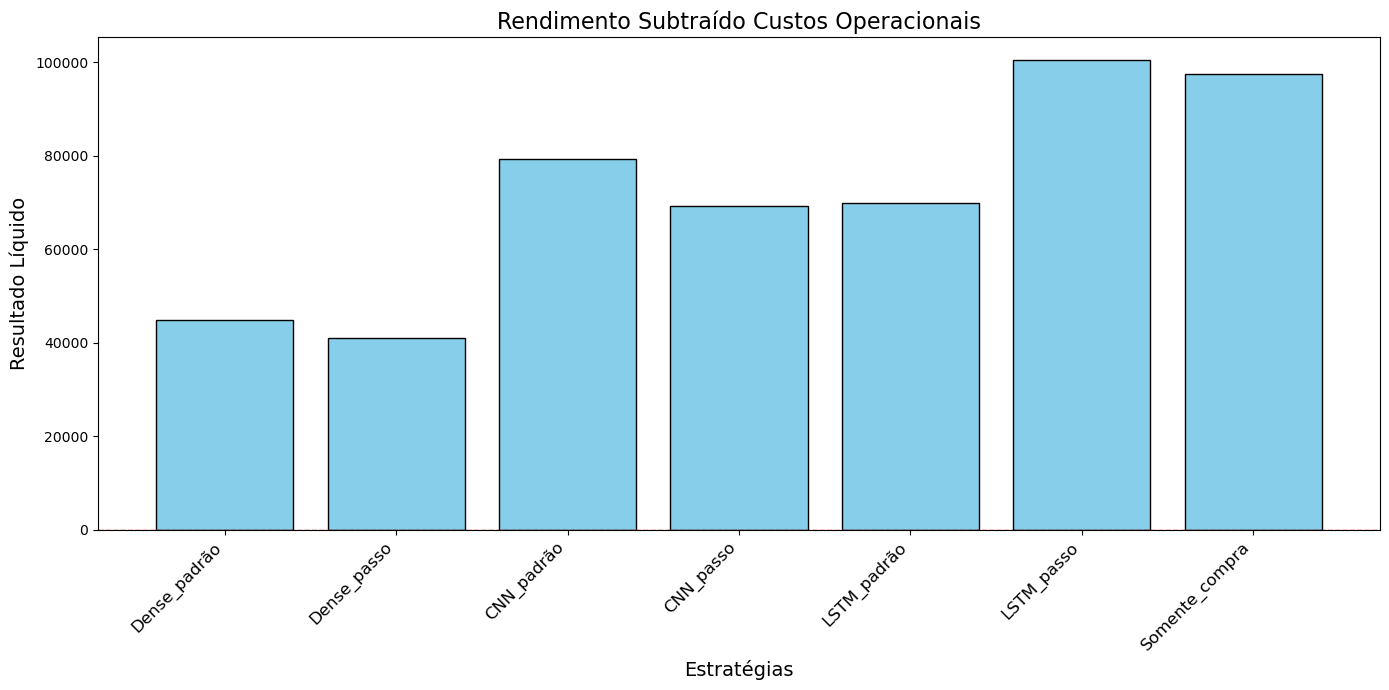

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista de arquivos
arquivos = [
    'negociações_valores_historico_5ano_Dense_default.csv',
    'negociações_valores_historico_5ano_Dense_step.csv',
    'negociações_valores_historico_5ano_CNN_default.csv',
    'negociações_valores_historico_5ano_CNN_step.csv',
    'negociações_valores_historico_5ano_LSTM_default.csv',
    'negociações_valores_historico_5ano_LSTM_step.csv'
]

# Listas para resultados e rótulos
resultados = []
labels = []

# Calculando o somatório e subtraindo os custos
for idx, arquivo in enumerate(arquivos):
    df = pd.read_csv(arquivo)

    # Criando rótulos ajustados
    partes = arquivo.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"
    
    # Soma dos valores e cálculo do resultado líquido
    soma_valores = df['Valores'].sum()  # Soma dos valores
    custo = custos_operacionais_dict[label]
    resultado_liquido = soma_valores - custo  # Subtração dos custos operacionais
    resultados.append(resultado_liquido)

    label = label.replace("step", "passo").replace("default", "padrão")
    labels.append(label)
# Somente Compra
data_inicio = pd.to_datetime('2005-01-31')
data_final = pd.to_datetime('2024-11-07')

dados_df = pd.read_csv('data/ibovespa_2000_2024.csv')
dados_df['Date'] = pd.to_datetime(dados_df['Date'])
dados_df = dados_df[(dados_df['Date'] >= data_inicio) & (dados_df['Date'] <= data_final)]
dados_df['Valor'] = dados_df['Adj Close'] - dados_df['Adj Close'].iloc[0]

# Custo para a estratégia "Somente Compra"
custo_inicial_final = 12 + (dados_df.iloc[0]['Adj Close'] + dados_df.iloc[-1]['Adj Close']) * 0.0003
soma_preco = 0
mes_count = 0

for i, (_, row) in enumerate(dados_df.iterrows()):
    if (i + 1) % 21 == 0:  # Simula operações mensais
        preco = row['Adj Close']
        soma_preco += preco
        mes_count += 1

custos = (mes_count * 12) + 0.0003 * soma_preco
resultado_liquido = dados_df.iloc[-1]['Valor'] - custos - custo_inicial_final
resultados.append(resultado_liquido)  # Armazena o resultado

# Adicionando o rótulo "Somente Compra"
labels.append("Somente_compra")

# Criando o gráfico de barras com cores diferenciadas
plt.figure(figsize=(14, 7))
plt.bar(labels, resultados, color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Linha indicando zero no eixo Y

# Ajustando título e rótulos
plt.title('Rendimento Subtraído Custos Operacionais', fontsize=16)
plt.xlabel('Estratégias', fontsize=14)
plt.ylabel('Resultado Líquido', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Ajusta o layout para evitar cortes e sobreposição
plt.tight_layout()
plt.savefig('Plots/Rendimentos Subtraíndo Custos Operacionais.jpg')

## 3.3 Desempenho em crises

Estratégia: Dense_padrão - Rendimento: -27475.0
Estratégia: Dense_passo - Rendimento: -12192.0
Estratégia: CNN_padrão - Rendimento: -19092.0
Estratégia: CNN_passo - Rendimento: -23001.0
Estratégia: LSTM_padrão - Rendimento: -5752.0
Estratégia: LSTM_passo - Rendimento: -33885.0
Estratégia: Somente-Compra - Rendimento: -43700.0


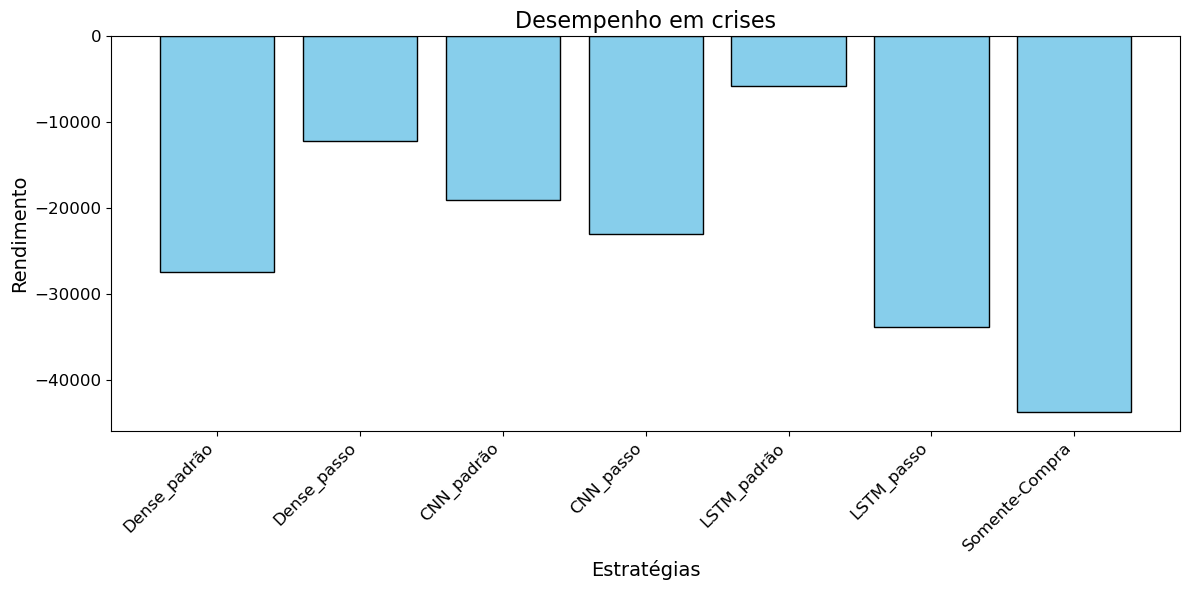

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Lista de arquivos CSV
arquivos = [
    'profit_by_date_historico_5ano_Dense_default.csv',
    'profit_by_date_historico_5ano_Dense_step.csv',
    'profit_by_date_historico_5ano_CNN_default.csv',
    'profit_by_date_historico_5ano_CNN_step.csv',
    'profit_by_date_historico_5ano_LSTM_default.csv',
    'profit_by_date_historico_5ano_LSTM_step.csv'
]

# Definindo os dois intervalos de datas
intervalo_1_inicial = '2007-09-01'
intervalo_1_final = '2009-03-31'

intervalo_2_inicial = '2019-09-01'
intervalo_2_final = '2021-01-06'     

# Lista para armazenar os resultados e os rótulos
resultados = []
labels = []

# Processando cada arquivo
for i, arquivo in enumerate(arquivos):
    df = pd.read_csv(arquivo)
    # Convertendo a coluna 'Date' para o tipo datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filtrando os dados para o primeiro intervalo
    df_filtrado_1 = df[(df['Date'] >= intervalo_1_inicial) & (df['Date'] <= intervalo_1_final)]
    if not df_filtrado_1.empty:
        profit_inicial_1 = df_filtrado_1.iloc[0]['Profit']  # Valor de Profit no início
        profit_final_1 = df_filtrado_1.iloc[-1]['Profit']  # Valor de Profit no fim
        diff_1 = profit_final_1 - profit_inicial_1  # Diferença entre o final e o início
    else:
        diff_1 = 0  # Caso o intervalo esteja vazio ou não haja dados

    # Filtrando os dados para o segundo intervalo
    df_filtrado_2 = df[(df['Date'] >= intervalo_2_inicial) & (df['Date'] <= intervalo_2_final)]
    if not df_filtrado_2.empty:
        valor_somar = df_filtrado_2.loc[df_filtrado_2['Date'] == '2020-05-18', 'Profit'].values[0]
        df_filtrado_2.loc[df_filtrado_2['Date'] > '2020-05-18', 'Profit'] += valor_somar

        profit_inicial_2 = df_filtrado_2.iloc[0]['Profit']  # Valor de Profit no início
        profit_final_2 = df_filtrado_2.iloc[-1]['Profit']  # Valor de Profit no fim
        diff_2 = profit_final_2 - profit_inicial_2  # Diferença entre o final e o início
    else:
        diff_2 = 0  # Caso o intervalo esteja vazio ou não haja dados
    
    # Somando as diferenças dos dois intervalos
    soma_diff = diff_1 + diff_2
    resultados.append(soma_diff)
    
    # Criando rótulo a partir da parte [5] e [6] do nome do arquivo
    partes = arquivo.split('_')
    label = f"{partes[-2]}_{partes[-1].split('.')[0]}"  # Remove a extensão do arquivo na parte [5]
    label = label.replace('default', 'padrão').replace('step', 'passo')  # Modificando para 'padrão' e 'passo'
    labels.append(label)

# Somente compra

# Ler e processar dados de preços ajustados
data_inicio = df['Date'].min()
data_final = df['Date'].max()
dados_df = pd.read_csv('data/ibovespa_2000_2024.csv')
dados_df['Date'] = pd.to_datetime(dados_df['Date'])
dados_df = dados_df[dados_df['Date'] <= data_final]
dados_df = dados_df[dados_df['Date'] >= data_inicio]
dados_df['Valor'] = dados_df['Adj Close'] - dados_df['Adj Close'].iloc[0]

df_filtrado_1 = dados_df[(dados_df['Date'] >= intervalo_1_inicial) & (dados_df['Date'] <= intervalo_1_final)]
diff_1 = df_filtrado_1.iloc[-1]['Valor'] - df_filtrado_1.iloc[0]['Valor']

df_filtrado_2 = dados_df[(dados_df['Date'] >= intervalo_2_inicial) & (dados_df['Date'] <= intervalo_2_final)]
diff_2 = df_filtrado_2.iloc[-1]['Valor'] - df_filtrado_2.iloc[0]['Valor']

soma_diff = diff_1 + diff_2
resultados.append(soma_diff)
label = "Somente-Compra"
labels.append(label)

for label, resultado in zip(labels, resultados):
    print(f"Estratégia: {label} - Rendimento: {resultado}")

# Criando o gráfico de colunas com cores diferentes
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, resultados, color='skyblue', edgecolor='black')

# Adicionando título e rótulos
plt.title('Desempenho em crises', fontsize=16)
plt.xlabel('Estratégias', fontsize=14)
plt.ylabel('Rendimento', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotacionando os rótulos dos arquivos para não sobrepor
plt.yticks(fontsize=12)

# Ajustando o layout para não cortar os rótulos
plt.tight_layout()

plt.savefig('Plots/Desempenho_durante_crises.jpg')


# 8. Tabela Resultados Anuais

In [15]:
import pandas as pd

# Lista com os nomes dos arquivos CSV
arquivos_csv = [
    'profit_by_date_historico_5ano_CNN_default.csv',
    'profit_by_date_historico_5ano_CNN_step.csv',
    'profit_by_date_historico_5ano_Dense_default.csv',
    'profit_by_date_historico_5ano_Dense_step.csv',
    'profit_by_date_historico_5ano_LSTM_default.csv',
    'profit_by_date_historico_5ano_LSTM_step.csv'
]

# Inicializando uma lista para armazenar os DataFrames
dfs = []

# Iterando sobre os arquivos e lendo os dados
for arquivo in arquivos_csv:
    df = pd.read_csv(arquivo)  # Lê o arquivo CSV
    df['Date'] = pd.to_datetime(df['Date'])  # Converte a coluna 'Date' para datetime
    
    # Extraindo os dois últimos nomes do arquivo (separados por '_')
    nome_modelo = '_'.join(arquivo.split('_')[-2:]).replace('.csv', '')
    df['Modelo'] = nome_modelo  # Adiciona uma coluna 'Modelo' com o nome extraído

    # Somando 'Profit' conforme a lógica fornecida
    valor_somar = df.loc[df['Date'] == '2010-03-09', 'Profit'].values[0]
    df.loc[(df['Date'] > '2010-03-09') & (df['Date'] < '2015-04-13'), 'Profit'] += valor_somar

    valor_somar = df.loc[df['Date'] == '2015-04-10', 'Profit'].values[0]
    df.loc[(df['Date'] >= '2015-04-13') & (df['Date'] <= '2020-05-18'), 'Profit'] += valor_somar

    valor_somar = df.loc[df['Date'] == '2020-05-18', 'Profit'].values[0]
    df.loc[df['Date'] > '2020-05-18', 'Profit'] += valor_somar

    dfs.append(df)  # Adiciona o DataFrame à lista

# Concatenando todos os DataFrames em um único DataFrame
df_completo = pd.concat(dfs, ignore_index=True)

# Extraindo o ano da coluna 'Date'
df_completo['Ano'] = df_completo['Date'].dt.year

# Encontrar o último dia de cada ano para cada modelo
df_ultimo_dia = df_completo.sort_values(by=['Modelo', 'Ano', 'Date']).drop_duplicates(subset=['Ano', 'Modelo'], keep='last')

# Selecionando apenas a coluna 'Profit' para os últimos dias de cada ano
df_ultimo_dia = df_ultimo_dia[['Modelo', 'Ano', 'Profit']]

# Pivotando o DataFrame para ter os anos como colunas e os modelos como linhas
df_pivot = df_ultimo_dia.pivot(index='Modelo', columns='Ano', values='Profit')


# Verificando se '2010' está disponível antes de tentar acessá-lo
if 2005 in df_pivot.columns:
    # Subtraindo o valor do ano seguinte pelo ano anterior
    df_pivot_diff = df_pivot.diff(axis=1)

    # Deixando o primeiro ano com o valor normal (sem alteração)
    df_pivot_diff[2005] = df_pivot[2005]
df_pivot_diff

Ano,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Modelo,,,,,,,,,,,,,,,,,,,,
CNN_default,2213.0,5375.0,18874.0,-792.0,25724.0,2913.0,-3591.0,155.0,-12389.0,7405.0,1999.0,17075.0,17004.0,-843.0,23295.0,-9447.0,-7598.0,727.0,26743.0,-4541.0
CNN_step,9105.0,11018.0,19412.0,-26336.0,31038.0,314.0,-12551.0,4198.0,-9445.0,-1500.0,-5027.0,4375.0,1139.0,2926.0,9088.0,27920.0,-14484.0,5209.0,24154.0,-4503.0
Dense_default,9363.0,9084.0,15103.0,-20450.0,23074.0,-1528.0,-6419.0,2888.0,-1502.0,-1013.0,1738.0,6169.0,17351.0,18066.0,8164.0,1292.0,-10708.0,9093.0,14290.0,-5732.0
Dense_step,6469.0,9739.0,13421.0,-18841.0,20987.0,-674.0,-12551.0,4198.0,-9445.0,-1500.0,495.0,-5118.0,2714.0,-2410.0,4733.0,28758.0,-14484.0,5209.0,24154.0,-4503.0
LSTM_default,5381.0,-972.0,16245.0,-12661.0,26772.0,-6526.0,-1445.0,-776.0,-4070.0,5563.0,8730.0,-1977.0,7445.0,11350.0,10802.0,27695.0,2579.0,3240.0,-4249.0,7879.0
LSTM_step,9105.0,11018.0,19412.0,-26336.0,31038.0,-497.0,-2117.0,3752.0,-2881.0,2868.0,-15436.0,10642.0,10017.0,13330.0,23966.0,12247.0,-14484.0,5209.0,24154.0,-4503.0


In [14]:
import pandas as pd

# Definindo o intervalo de datas
data_inicio = pd.to_datetime('2005-01-31')
data_final = pd.to_datetime('2024-11-07')

# Carregando os dados
dados_df = pd.read_csv('data/ibovespa_2000_2024.csv')

# Convertendo a coluna 'Date' para o formato datetime
dados_df['Date'] = pd.to_datetime(dados_df['Date'])

# Filtrando os dados dentro do intervalo de datas
dados_df = dados_df[dados_df['Date'] <= data_final]
dados_df = dados_df[dados_df['Date'] >= data_inicio]

# Calculando a variação em relação ao primeiro valor de 'Adj Close'
dados_df['Valor'] = dados_df['Adj Close'] - dados_df['Adj Close'].iloc[0]

# Encontrando o último dia de cada ano
dados_df['Ano'] = dados_df['Date'].dt.year
df_ultimo_dia = dados_df.sort_values(by=['Ano', 'Date']).drop_duplicates(subset=['Ano'], keep='last')

# Subtraindo o valor do ano anterior (2006 - 2005, 2007 - 2006, etc.)
df_ultimo_dia['Valor_Subtraido'] = df_ultimo_dia['Valor'] - df_ultimo_dia['Valor'].shift(1)

# Para o ano de 2005, o valor não será alterado (não há ano anterior)
df_ultimo_dia['Valor_Subtraido'].iloc[0] = df_ultimo_dia['Valor'].iloc[0]

# Adicionando a coluna de "Modelo"
# Aqui você deve adicionar os modelos de acordo com seus dados.
# Exemplo fictício: adicionando os modelos aos dados (você deve ter esses valores em seu DataFrame real).
df_ultimo_dia['Modelo'] = 'Somente_compra'  # Substitua por modelos reais

# Pivotando o DataFrame para ter os anos como colunas e os modelos como linhas
df_pivot = df_ultimo_dia.pivot(index='Modelo', columns='Ano', values='Valor_Subtraido')

# Exibindo o DataFrame pivotado
df_pivot = df_pivot.fillna(0)  # Preenche valores ausentes com 0, se necessário
df_pivot

C:\Users\marlo\AppData\Local\Temp\ipykernel_8008\3798808686.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_dia['Valor_Subtraido'].iloc[0] = df_ultimo_dia['Valor'].iloc[0]


Ano,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Modelo,,,,,,,,,,,,,,,,,,,,
Somente_compra,9105.0,11018.0,19412.0,-26336.0,31038.0,717.0,-12551.0,4198.0,-9445.0,-1500.0,-6657.0,16877.0,16175.0,11485.0,28077.0,3342.0,-14484.0,5209.0,24154.0,-4503.0
